mainly looking at https://github.com/ngessert/isic2019/blob/master/models.py

# start

In [1]:
PRFX = 'Mel0626A4'
PRFX_PREP = 'MelPrp0626A2'
ARCH = 'efficientnet-b0'
SZ = 224
EPOCHS = 10
BS = 128
K=5; SEED=101; FLD2USE=0
FP16 = False

LR=3e-5
MOMENTUM=0.9
WD=0.


N_SAMPL = int(1e3)

DEBUG = True
if DEBUG: 
    EPOCHS=3
    K = 2
    N_SAMPL = 2000
    
DEVICE = 'cuda'; PIN_MEM = (DEVICE=='cuda')

In [2]:
!nvidia-smi

Sat Jun 27 01:23:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    83W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.metrics import accuracy_score as acuuracy

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from efficientnet_pytorch import EfficientNet

from apex import amp

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(SEED)



# p_out=f'../output/{PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
# p_cmp = '../input/siim-isic-melanoma-classification'



# prep

In [4]:
# train,test,sample_submission = (pd.read_csv(o, nrows=100 if DEBUG else None) 
#                                 for o in [f'{p_cmp}/{o}.csv' 
#                                           for o in ('train', 'test', 'sample_submission')])
# print([o.shape for o in (train,test,sample_submission)])
# display(test.head(2))
# p_19 = '../input/andrewmvd--isic-2019'

p_prp = f'../output/{PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all.csv') 
print(dftrn.shape)

set_seed(SEED); dftrn = dftrn.sample(frac=1.)

if N_SAMPL is not None: dftrn = dftrn.head(N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58457, 4)


,source,im_pth,patient_id,target
24437,20,../input/siim-isic-melanoma-classification/jpe...,IP_4021847,0.0
57432,19,../input/andrewmvd--isic-2019/ISIC_2019_Traini...,BCN_0004730,1.0


(2000, 4)

20    1096
19     904
Name: source, dtype: int64

source
19    0.184735
20    0.018248
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

72


In [6]:
set_seed(SEED)
kf = GroupKFold(n_splits=K)
fld2trvl={fld:(tr,vl) for fld,(tr,vl) in enumerate(kf.split(dftrn, groups=dftrn.patient_id))}

for fld, (tr, vl) in fld2trvl.items():
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in fld2trvl.items():
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())


0 1000 1000
1 1000 1000


0.0    0.912
1.0    0.088
Name: target, dtype: float64

0.0    0.901
1.0    0.099
Name: target, dtype: float64

20    559
19    441
Name: source, dtype: int64

20    537
19    463
Name: source, dtype: int64

## load images

In [7]:
%%time
im_pil = Image.open(dftrn.im_pth.sample().values[0])

CPU times: user 10.7 ms, sys: 716 µs, total: 11.4 ms
Wall time: 31 ms


In [8]:
ims_pil = []
for im_pth in tqdm(dftrn.im_pth):
    ims_pil.append(Image.open(im_pth))
### faster to preload images
# i = np.random.choice(range(len(dftrn)))
# %%timeit 
# im_pil = Image.open(dftrn.im_pth.values[i])
# %%timeit 
# im_pil = ims_pil[i]

100%|██████████| 2000/2000 [00:00<00:00, 2776.08it/s]


# dataset

In [9]:
class MelDataset(Dataset):
    def __init__(self, imgs, targets=None):
        self.imgs = imgs
        self.targets = targets
        self.composed = transforms.Compose([
            transforms.RandomResizedCrop(SZ),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])    
    def __getitem__(self, i):
        x = self.imgs[i]
        x = self.composed(x)
        if self.targets is not None:
            y = self.targets[i]
            return x, y
        else:
            return x,
    
    def __len__(self):
        return len(self.imgs)    

In [10]:
# ds_trn = MelDataset(ims_pil, dftrn.target.values)
# ds_trn[0][0].shape, ds_trn[0][1]

# plt.imshow(ds_trn[0][0].numpy().transpose(1,2,0));
# plt.show()

# dl_trn = DataLoader(ds_trn, batch_size=BS, shuffle=True, num_workers=4, pin_memory=PIN_MEM)
# for dat in dl_trn:
#     x,y=dat; break

# print(x.shape, y)

# del ds_trn; gc.collect()

# model

In [11]:
# mdl = EfficientNet.from_pretrained(ARCH, num_classes=1)
# mdl(x).shape

# train

In [12]:
tr,vl=fld2trvl[FLD2USE]
dftr=dftrn.iloc[tr]
dfvl=dftrn.iloc[vl]
ystr=dftr.target.values
ysvl=dfvl.target.values
print(len(dftr), len(dfvl))
dstr = MelDataset([ims_pil[o] for o in tr], ystr)
dsvl = MelDataset([ims_pil[o] for o in vl], ysvl)
print(len(dstr), len(dsvl))
dltr = DataLoader(dstr, batch_size=BS,   shuffle=True,  num_workers=4, pin_memory=PIN_MEM)
dlvl = DataLoader(dsvl, batch_size=BS*2, shuffle=False, num_workers=4, pin_memory=PIN_MEM)
print(len(dltr), len(dlvl))

1000 1000
1000 1000
8 4


In [13]:
def evaluate(ys, model, dl):
    with torch.no_grad():
        model.eval()
        prd = []
        for step, batch in enumerate(dl):
            xb, yb=(o.to(device) for o in batch)
            prdb = model(xb)
            prd.append(prdb.cpu().detach().numpy())
        prd = np.concatenate(prd)    
        lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(ys).unsqueeze(1)).item()
        scr = roc_auc(ys, prd)
    return lss, scr

In [14]:
mdl = EfficientNet.from_pretrained(ARCH, num_classes=1)
mdl = mdl.to(device)

opt = optim.SGD(mdl.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WD)
# schdl = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=PLTFACTOR, patience=PATIENCE, min_lr=MIN_LR, verbose=True)

mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)

Loaded pretrained weights for efficientnet-b0


## run train

In [15]:
stats = {
    'lss': {'tr':[],'vl':[]},
    'scr': {'tr':[],'vl':[]},
}
best_scr=float('-inf')

for epc in range(EPOCHS):
    prdtr_ep=[]
    ytr_ep=[]
    for step, dat in enumerate(dltr):
        mdl.train()
        xb,yb=(o.to(device) for o in dat)
        yb=yb.unsqueeze(1)
        prdb = mdl(xb)
        loss = F.binary_cross_entropy_with_logits(prdb, yb)
        if FP16:
            with amp.scale_loss(loss, opt) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        if FP16:
            torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
        else:
            torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
        opt.step()
        mdl.zero_grad()
        prdtr_ep.append(prdb.cpu().detach().numpy())
        ytr_ep.append(yb.cpu().detach().numpy())
        if step%1000==0: 
            print(dtnow(), f'ep {epc} step {step}')
    
    prdtr_ep = np.concatenate(prdtr_ep)
    ytr_ep = np.concatenate(ytr_ep)    
    lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
    scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
    stats['lss']['tr'].append(lss_tr_ep)
    stats['scr']['tr'].append(scr_tr_ep)
    
    lss_vl_ep, scr_vl_ep = evaluate(ysvl, mdl, dlvl)
    stats['lss']['vl'].append(lss_vl_ep)
    stats['scr']['vl'].append(scr_vl_ep)
    print(dtnow(), f'ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; ')
    
    if scr_vl_ep>best_scr:
        print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
        best_scr=scr_vl_ep
#     schdl.step(lossval)  # Update learning rate schedule
        
    

2020-06-27 01:24:20 ep 0 step 0
2020-06-27 01:27:40 ep 0: lss_tr 0.708; lss_vl 0.804; scr_tr 0.573; scr_vl 0.494; 
better scr -inf -> 0.494
2020-06-27 01:28:33 ep 1 step 0
2020-06-27 01:31:37 ep 1: lss_tr 0.712; lss_vl 0.711; scr_tr 0.490; scr_vl 0.487; 
2020-06-27 01:32:34 ep 2 step 0
2020-06-27 01:35:21 ep 2: lss_tr 0.707; lss_vl 0.692; scr_tr 0.527; scr_vl 0.438; 


## run done

In [16]:
print(f'best_scr {best_scr:.4f}')

best_scr 0.4936


In [17]:
pd.DataFrame(stats['lss'])

,tr,vl
0,0.707994,0.803950
1,0.711963,0.711310
2,0.706707,0.692392


In [18]:
pd.DataFrame(stats['scr'])

,tr,vl
0,0.572530,0.493582
1,0.490113,0.487040
2,0.527437,0.437729


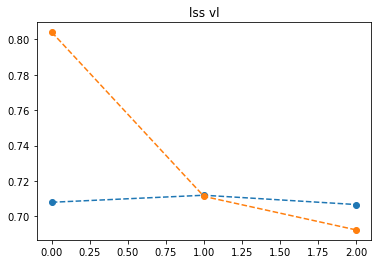

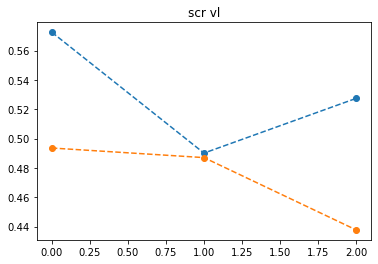

In [23]:
for k,v in stats.items():
    for tv,vs in v.items():
        plt.title(f'{k} {tv}')
        plt.plot(vs, 'o--')
    plt.show()

In [ ]:
pickle.dump(stats, open(f'{p_out}/stats.p', 'wb'))

# fin

In [20]:
print(f'best_scr {best_scr:.4f}')

best_scr 0.4936


In [21]:
PRFX

'Mel0626A4'

In [22]:
!nvidia-smi

ValueError: filedescriptor out of range in select()